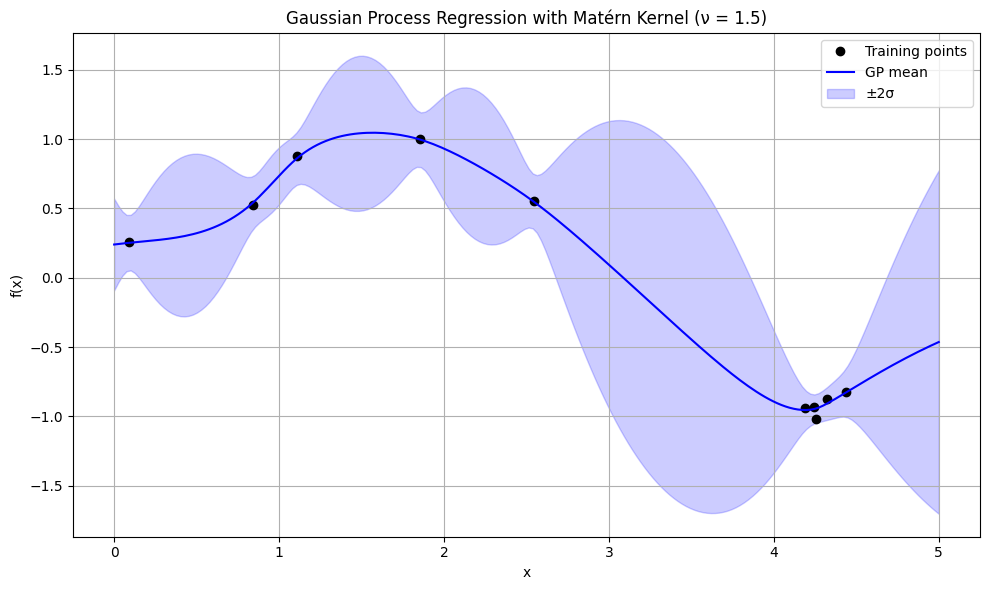

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.special import kv, gamma

# Matérn 3/2 kernel (ν = 1.5)
def matern_kernel(x1, x2, length_scale=1.0, sigma_f=1.0, nu=1.5):
    x1, x2 = np.atleast_2d(x1), np.atleast_2d(x2)
    r = cdist(x1, x2, metric='euclidean')
    if nu == 1.5:
        sqrt3_r = np.sqrt(3) * r / length_scale
        return sigma_f**2 * (1 + sqrt3_r) * np.exp(-sqrt3_r)
    elif nu == 2.5:
        sqrt5_r = np.sqrt(5) * r / length_scale
        return sigma_f**2 * (1 + sqrt5_r + 5*r**2/(3*length_scale**2)) * np.exp(-sqrt5_r)
    else:
        raise NotImplementedError("Only ν=1.5 and ν=2.5 are implemented.")

# Training data
X_train_matern = np.sort(np.random.uniform(0, 5, 10)).reshape(-1, 1)
y_train_matern = np.sin(X_train_matern).ravel() + 0.1 * np.random.randn(len(X_train_matern))

# Test points
X_test_matern = np.linspace(0, 5, 200).reshape(-1, 1)

# Hyperparameters
ell = 1.0        # length scale
sigma_f = 1.0    # signal std
sigma_n = 0.1    # observation noise std
nu = 1.5         # smoothness
p = nu - 0.5 # p = ν - 0.5 for Matérn kernel

# Compute kernels
K = matern_kernel(X_train_matern, X_train_matern, ell, sigma_f, nu) + sigma_n**2 * np.eye(len(X_train_matern))
K_s = matern_kernel(X_train_matern, X_test_matern, ell, sigma_f, nu)
K_ss = matern_kernel(X_test_matern, X_test_matern, ell, sigma_f, nu)

# GPR predictive mean and covariance
K_inv = np.linalg.inv(K)
mu_s = K_s.T @ K_inv @ y_train_matern
cov_s = K_ss - K_s.T @ K_inv @ K_s
std_s = np.sqrt(np.diag(cov_s))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(X_train_matern, y_train_matern, 'ko', label="Training points")
plt.plot(X_test_matern, mu_s, 'b-', label="GP mean")
plt.fill_between(X_test_matern.ravel(), mu_s - 2*std_s, mu_s + 2*std_s,
                 alpha=0.2, color='blue', label="±2σ")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Gaussian Process Regression with Matérn Kernel (ν = 1.5)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


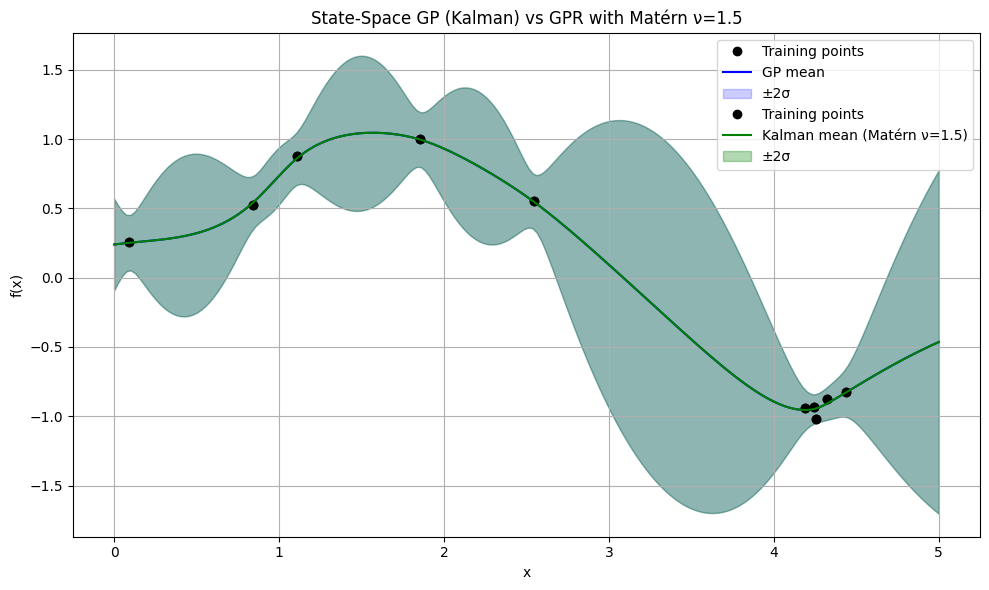

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, solve_continuous_lyapunov
from scipy.special import gamma
from gp_preprocess import gp_matern_fast

ell = 1.0
sigma_f = 1.0
sigma_n = 0.1

X_train = X_train_matern.flatten()
y_train = y_train_matern
X_test = X_test_matern.flatten()

mean_test, std_test = gp_matern_fast(X_train, y_train, X_test, ell, sigma_f, sigma_n)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(X_train_matern, y_train_matern, 'ko', label="Training points")
plt.plot(X_test_matern, mu_s, 'b-', label="GP mean")
plt.fill_between(X_test_matern.ravel(), mu_s - 2*std_s, mu_s + 2*std_s,
                 alpha=0.2, color='blue', label="±2σ")
plt.plot(X_train_matern, y_train_matern, 'ko', label="Training points")
plt.plot(X_test_matern, mean_test, 'g-', label="Kalman mean (Matérn ν=1.5)")
plt.fill_between(X_test_matern.ravel(), mean_test - 2*std_test, mean_test + 2*std_test,
                 alpha=0.3, color='green', label="±2σ")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("State-Space GP (Kalman) vs GPR with Matérn ν=1.5")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
